# Tutorial: Multivariate CaStLe (M-CaStLe) at a Glance

This notebook steps you through the **multivariate extension** to the original univariate CaStLe toolbox.  At its heart is the idea of a **spatial “stencil”**—a local 3×3 window of grid‐cell interactions—that we use to discover space–time causal structure in coupled, multivariate fields.

---

## 1. Space–Time Causal Graphs & the Moore Neighborhood

- **Space–time causal graph**  
  A directed network whose nodes are “variable at (cell, time)”.  Edges encode “does X at time t help predict Y in a neighboring cell at time t+1?”  

- **Moore neighborhood**  
  The 3×3 block centered on a grid cell (the 8 surrounding cells plus itself).  Local interactions in many physical or ecological systems are naturally captured by this pattern.

---

## 2. From Local Stencils to Global Graphs

1. **Local stencil representation**  
   – For *N* variables, build a 3×3×N local coefficient array.  
   – Each “child” variable at the center (row=1,col=1) at time t+1 may depend on *every* variable in each of the 3×3 positions at time t.  

2. **Reduced “neighborhood” coordinate space**  
   – Flatten each cell’s 3×3×N block into a single vector.  
   – Concatenate across time to form a T×(9N) data matrix per cell.  

3. **Causal discovery in reduced space**  
   – Run a time series causal discovery algorithm on the T×(9N) series.
   – Enforce link‐assumptions (e.g., only center‐to‐neighbor, no long‐range) to regularize inference.  

4. **Map the learned stencil back to the full grid**  
   – Every cell “inherits” the same 9N×9N local graph.  
   – Stitch these local stencils together to recover a global (grid_size²·N)² causal graph.  

5. **Decompositions**  
   – **Reaction graph (N×N)**: aggregated variable‐to‐variable effects.  
   – **Spatial graph (9×9)**: directional signature of influences in the Moore block.  

---

## 3. Why Multivariate?

The original CaStLe code operated on one variable per grid cell.  Real-world spatio-temporal systems—climate models, ecological surveys, neural recordings—are **multivariate**: each location carries several interacting quantities.  M-CaStLe generalizes the stencil approach to handle:

- **Cross-variable influences** (A→B)  
- **Spatial couplings** in each variable  
- **Mixed feedbacks** and self-dependencies  

By learning a **local multivariate stencil**, we can infer rich, high-dimensional causal networks without ever fitting one enormous global model.

---

## 4. End-to-End Workflow

1. **Define or randomly generate** a ground-truth 3×3×N stencil of coefficients.  
2. **Simulate** T time-steps of multivariate data on a toroidal grid.  
3. **Project** each cell’s Moore‐neighborhood series into the reduced (9N)‐dimensional space.  
4. **Discover** the local stencil with `mv_CaStLe_PC` or `mv_CaStLe_DYNOTEARS`.  
5. **Visualize** ground-truth vs. learned stencils, reaction graph, and summary spatial graph.  
6. **Quantitatively evaluate** precision/recall, F₁, MCC, and FDR.  

Throughout this tutorial you will lean on the **multivariate_stencil** utilities to build, map, visualize, and assess your causal models.

## 1. Setup

In [14]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="causalnex.structure.transformers")

# Tigramite for conditional-independence tests & PC
from tigramite.independence_tests.parcorr import ParCorr

# our modules (assumes they're in the same folder or PYTHONPATH)
sys.path.append("../src")
import spatiotemporal_SCM_data_generator as dg
import mcastle_utils as mcastle
import causal_graph_metrics as gm

## 2. Define & Simulate a Ground-Truth Stencil

### Multivariate Spatial Coefficient Structure Overview:

The multivariate spatial coefficient structure represents the dynamics of how multiple variables interact in the local Moore neighborhood over time. The descriptions below explain how this structure is represented in code. In essence, this is the structure M-CaStLe estimates and from which our synthetic data is generated. To generate the synthetic data, the structure is mapped to an equivalent structural causal model (mathematically described as a vector autoregression model), which is a temporal generative model.

#### Short Version

The multivariate spatial coefficient structure is a 4D structure (spatial_coefficients[var_child, row_pos, col_pos][var_parent]) representing how multiple variables interact across space over a single time step. Each coefficient quantifies how a parent variable at a specific position at time t influences a child variable at the center position at time t+1. This enables modeling systems with both spatial dynamics and variable interactions, where each variable's evolution depends on the spatial distribution of all variables at the previous time step.

`spatial_coefficients[child_var, row, col][parent_var]` captures how parent variables at different spatial positions (time t) influence child variables at center (time t+1).

#### Long Version

<details>
<summary><b>📖 Click to learn about spatial coefficient structure</b></summary>

The multivariate spatial coefficient structure extends the univariate case to handle multiple interacting variables across a Moore neighborhood, with all interactions occurring over a single time step. It is implemented as a 4D array with the format:

spatial_coefficients[var_child, row_pos, col_pos][var_parent]

Where:
- var_child (0 to n-1): Index of the variable being influenced at the next time step (the "child")
- row_pos (0 to 2): Row position in the Moore neighborhood
- col_pos (0 to 2): Column position in the Moore neighborhood
- var_parent (0 to n-1): Index of the variable exerting influence from the current time step (the "parent")

This structure captures complex spatio-temporal and cross-variable interactions:
1. Each variable at the center at time t+1 can be influenced by any variable (including itself) from any spatial position at time t
2. The coefficient value represents the strength and direction of influence
3. The central position is at row=1, col=1
4. Zero values indicate no influence

The multivariate structure enables modeling of coupled systems where multiple state variables interact both within and across spatial locations over discrete time steps. It supports complex dynamics such as:
- Cross-variable effects (how variable A at time t affects variable B at time t+1)
- Spatial dependencies (how values at different positions at time t affect the center at time t+1)
- Direction-dependent interactions (different effects from different directions)
- Self-reinforcing or self-inhibiting feedbacks (when parent and child are the same variable)

The coefficients appear in update equations of the form:

state(var_child, center, t+1) = sum_{var_parent, i, j} coefficient[var_child, i, j][var_parent] * state[var_parent, i, j, t]
</details>

##### Structure and dataset generation
We build a 3×3 “local” coefficient array for each child variable.  
Here `spatial_coefficients[c, row, col][p]` is the coefficient from parent p at offset (row,col) into child c.

In [15]:
T = 500
grid_size = 4
num_variables = 3

manual_coef_definition = False  # Manually define the structure or generate one at random?
if manual_coef_definition:
    # start with an all-zero structure
    spatial_coefficients = dg.get_empty_coefficient_matrix(n_variables=num_variables)

    # manually set five links
    # child 0 ← parent 0 at (0,2)
    spatial_coefficients[0, 0, 2][0] = -0.43

    # child 2 ← parent 0 at (0,2)
    spatial_coefficients[2, 0, 2][0] = 0.35

    # child 0 ← parent 1 at center (1,1)
    spatial_coefficients[0, 1, 1][1] = 0.85

    # child 2 ← parent 2 at (0,1)
    spatial_coefficients[2, 0, 1][2] = -0.74

    # child 2 ← parent 2 at (1,2)
    spatial_coefficients[2, 1, 2][2] = 0.13

    data = dg.generate_dataset(T=T, grid_size=grid_size, spatial_coefs=spatial_coefficients)
else:
    num_links = 5
    coefficient_min_value_threshold = 0.2
    spatial_coefficients, data = dg.generate_dataset(
        T=T,
        grid_size=grid_size,
        num_variables=num_variables,
        num_links=num_links,
        coefficient_min_value_threshold=coefficient_min_value_threshold,
        return_coefs=True,
        random_seed=123,
    )

print("spatial_coefficients shape (num_variables, 3, 3):", spatial_coefficients.shape)
print("data shape (num_variables, grid_size, grid_size, T):", data.shape)

spatial_coefficients shape (num_variables, 3, 3): (3, 3, 3)
data shape (num_variables, grid_size, grid_size, T): (3, 4, 4, 500)


Visualize one cell's series:

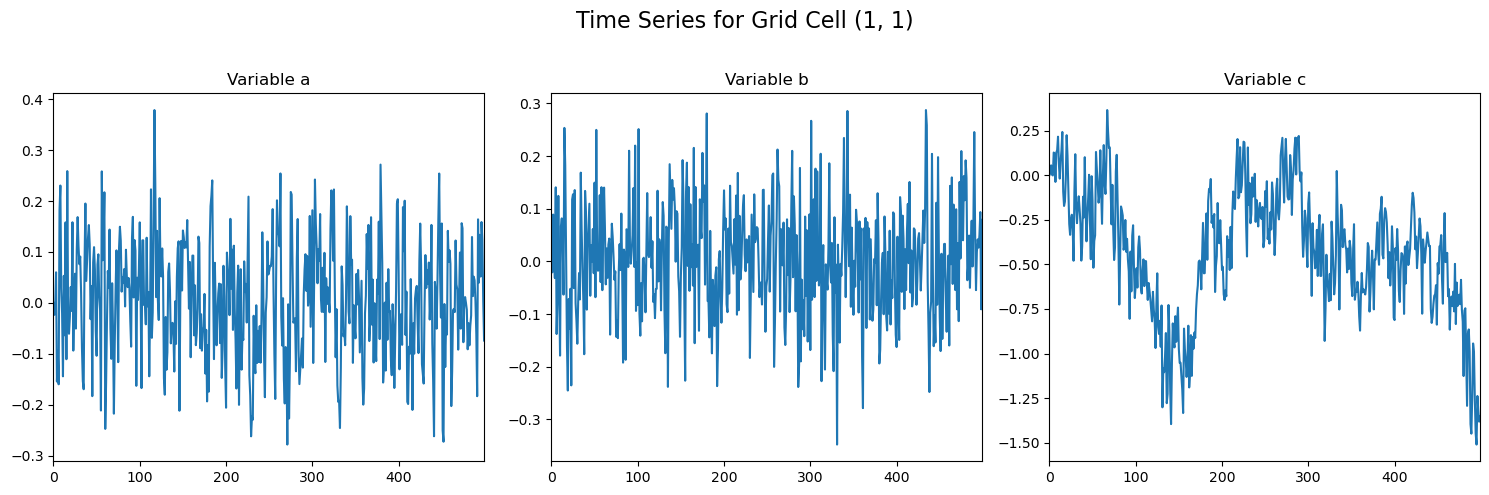

In [16]:
fig, axes = mcastle.plot_grid_cell_time_series(data, position=(1, 1))
plt.show()

## 3. Plot the Ground-Truth Stencil Graph

Convert coefficients → stencil graph (+ value matrix) → visualize.

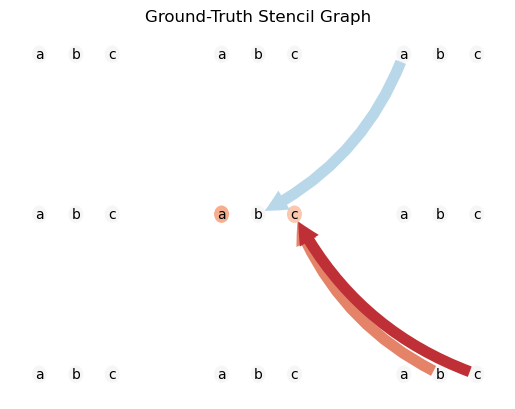

In [17]:
stencil_graph, stencil_val_matrix = mcastle.get_stencil_graph_from_coefficients(spatial_coefficients)

# pretty‐print the adjacency matrix (lag-1)
# mcastle.pretty_print_string_graph(stencil_graph[:,:,1])

# plot
fig, ax = mcastle.plot_stencil_graph(
    stencil_graph=stencil_graph,
    stencil_val_matrix=stencil_val_matrix,
)
ax.set_title("Ground-Truth Stencil Graph")
plt.show()

## 4. Build & Plot the Ground-Truth Reaction Graph

The codebase provides a helper function to extract the *reaction graph* and a *spatial graph* from the full stencil graph.
  
- The **reaction graph** aggregates how variables (across cells) influence each other.
- The **spatial graph** recaptures the spatial distribution of influences in a concise (9×9) matrix.
  
Let's compute and display these outputs.

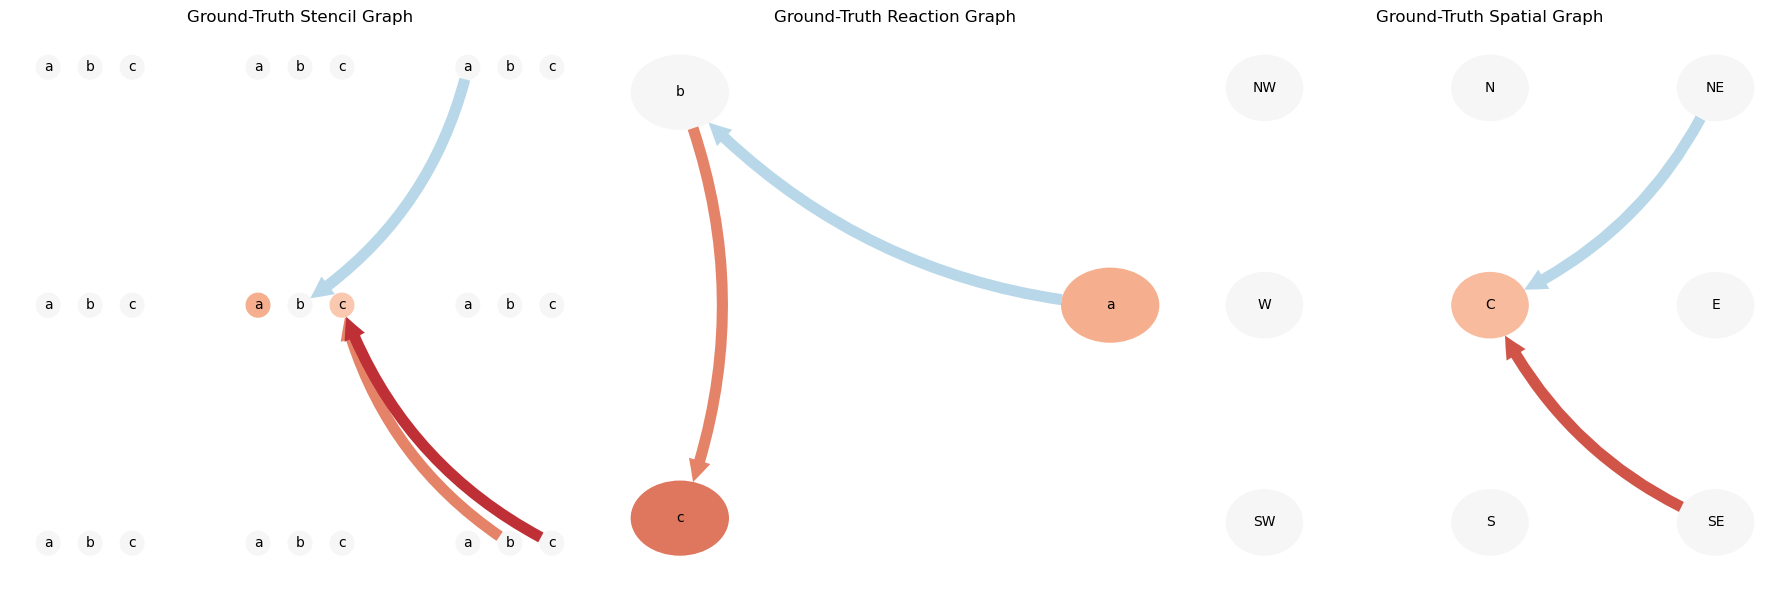

In [18]:
true_reaction_graph, true_reaction_vals, true_spatial_graph, true_spatial_val_matrix = mcastle.analyze_stencil_graphs(
    stencil_graph=stencil_graph, stencil_val_matrix=stencil_val_matrix
)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

mcastle.plot_stencil_graph(stencil_graph=stencil_graph, stencil_val_matrix=stencil_val_matrix, ax=axs[0], fig=fig)
axs[0].set_title("Ground-Truth Stencil Graph")

mcastle.plot_reaction_graph(
    reaction_graph=true_reaction_graph,
    reaction_val_matrix=true_reaction_vals,
    # show_colorbar=True,
    ax=axs[1],
    fig=fig,
)
axs[1].set_title("Ground-Truth Reaction Graph")

mcastle.plot_stencil_graph(
    stencil_graph=true_spatial_graph,
    stencil_val_matrix=true_spatial_val_matrix,
    directional_var_names=True,
    # show_colorbar=True,
    ax=axs[2],
    fig=fig,
)
axs[2].set_title("Ground-Truth Spatial Graph")

plt.tight_layout()
plt.show()

## 5. Run M-CaStLe Causal Discovery

M-CaStLe offers two causal discovery approaches with different algorithms:

### **M-CaStLe-PC** (Constraint-based)

Uses **PC-Stable algorithm** (time-series adapted) with conditional independence tests:
- `cond_ind_test`: Conditional independence test (e.g., ParCorr for linear dependencies)
- `pc_alpha`: Significance threshold for condition-selection step (default: 0.05). Acts as regularization parameter rather than strict significance level
- `cd_function`: 
  - `"run_pcalg"`: PC-Stable for time series (default) - discovers lagged links
  - `"run_pcmci"`: **PCMCI** - optimized for **strongly autocorrelated** time series. Uses Momentary Conditional Independence (MCI) tests that account for autocorrelation, common drivers, and indirect links. Actually *benefits* from autocorrelation whereas standard PC suffers from it
- `graph_p_threshold`: P-value threshold for including edges in final graph
- `fdr_method`: Multiple testing correction ("bh" for Benjamini-Hochberg)
- `strength_threshold`: Optional filter to remove weak edges
- `intervariable_link_assumptions`: Dict specifying cross-variable link constraints

### **M-CaStLe-DYNOTEARS** (Score-based)

Uses continuous optimization with DAG constraint:
- `dependence_threshold`: Minimum absolute coefficient to include edge (default: 0.01)
- `lambda_a`: **Primary sparsity tuning parameter.** L1 penalty for lagged edges. Higher (0.05-0.1) = very sparse graphs with only strongest links; lower (0.001-0.01) = more relationships including weaker inter-variable links (default: 0.01)
- `lambda_w`: L1 penalty for lag-0 edges. In M-CaStLe, lag-0 edges are banned via tabu_edges, so this mainly affects optimization dynamics. Recommended: set equal to lambda_a (default: None → uses lambda_a)
- `max_iter`: Maximum optimization iterations (default: 100, increase to 200-500 if convergence warnings)

### **Shared parameters**
- `rows_inverted`: True for synthetic data (inverts spatial indexing when row 0 is at top)
- `dependencies_wrap`: True for toroidal grid (wrap edges at boundaries)
- `allow_center_directed_links`: Allow directed child→child connections at center cell
- `verbose`: 0 (silent) or 1 (progress messages)

### **Which method to use?**

**Use PC-Stable (`cd_function="run_pcalg"`)** when:
- Ground truth is sparse
- You want p-values and statistical hypothesis testing
- You need interpretable independence tests

**Use PCMCI (`cd_function="run_pcmci"`)** when:
- Data has **strong autocorrelation** (PCMCI benefits from it!)
- Time resolution is coarse relative to causal time delays
- You want optimized conditioning sets for efficiency

**Use DYNOTEARS** when:
- You prefer continuous optimization over hypothesis testing
- Ground truth may be denser
- You want faster runtime (avoids iterative CI tests)
- Single regularization parameter (`lambda_a`) is less to tune

Choose your method below:

In [19]:
# Select causal discovery method
method = "DYNOTEARS"  # Options: "PC", "PCMCI", or "DYNOTEARS"

if method == "PC":
    ci_test = ParCorr(significance="analytic")
    results = mcastle.mv_CaStLe_PC(
        data,
        cond_ind_test=ci_test,
        pc_alpha=0.05,
        graph_p_threshold=0.05,
        cd_function="run_pcalg",  # PC-Stable for time series
        fdr_method="bh",
        min_tau=1,
        rows_inverted=True,
        dependencies_wrap=True,
        allow_center_directed_links=True,
        verbose=1,
    )
    learned_stencil_graph = results["graph"]
    learned_stencil_vals = results["val_matrix"]

elif method == "PCMCI":
    ci_test = ParCorr(significance="analytic")
    results = mcastle.mv_CaStLe_PC(
        data,
        cond_ind_test=ci_test,
        pc_alpha=0.05,
        graph_p_threshold=0.05,
        cd_function="run_pcmci",  # PCMCI for autocorrelated time series
        fdr_method="bh",
        min_tau=1,
        rows_inverted=True,
        dependencies_wrap=True,
        allow_center_directed_links=True,
        verbose=1,
    )
    learned_stencil_graph = results["graph"]
    learned_stencil_vals = results["val_matrix"]
    
elif method == "DYNOTEARS":
    results = mcastle.mv_CaStLe_DYNOTEARS(
        data,
        dependence_threshold=0.01,
        lambda_a=0.01,  # Primary sparsity control
        lambda_w=None,  # Defaults to lambda_a
        max_iter=100,
        rows_inverted=True,
        dependencies_wrap=True,
        allow_center_directed_links=True,
        verbose=1,
    )
    learned_stencil_graph = results[0]
    learned_stencil_vals = results[1]

print(f"Method used: {method}")
print("learned_stencil_graph.shape:", learned_stencil_graph.shape)

Data concatenated into multivariate Moore neighborhood space (shape (8000, 27))...
Running DYNOTEARS with 3 center nodes and 729 taboo edges...
Stencil learned...
Method used: DYNOTEARS
learned_stencil_graph.shape: (27, 27, 2)


## 6. Extract & Plot the Learned Stencil

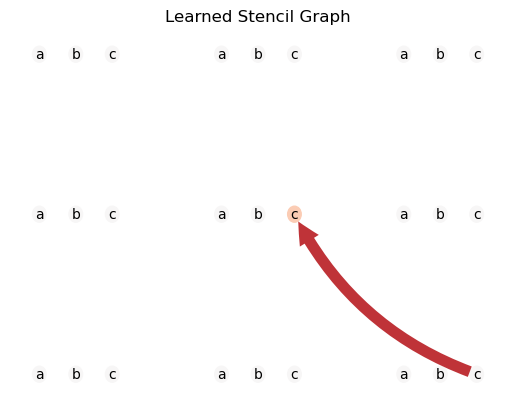

In [20]:
fig, ax = mcastle.plot_stencil_graph(
    stencil_graph=learned_stencil_graph,
    stencil_val_matrix=learned_stencil_vals,
)
ax.set_title("Learned Stencil Graph")
plt.show()

## 7. Extract & Plot the Learned Reaction & Spatial Graphs

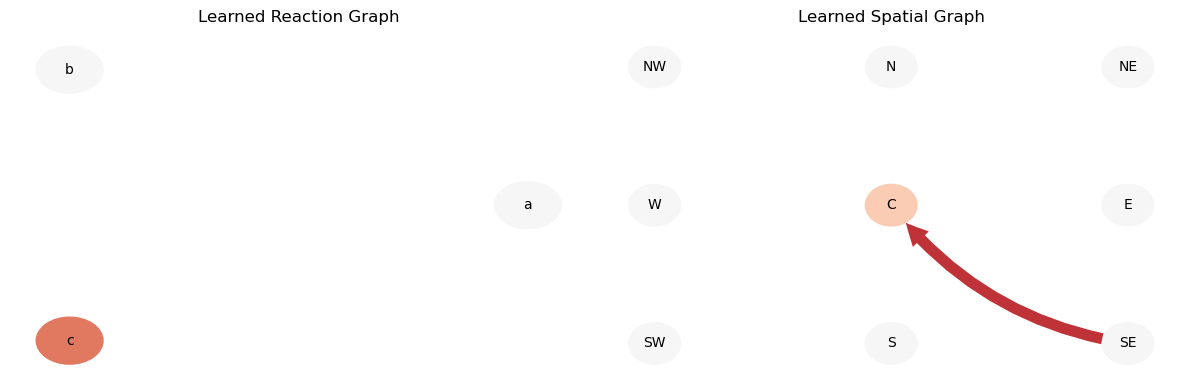

In [21]:
learned_reaction_graph, learned_reaction_vals, learned_spatial_graph, learned_spatial_val_matrix = mcastle.analyze_stencil_graphs(
    stencil_graph=learned_stencil_graph, stencil_val_matrix=learned_stencil_vals
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

mcastle.plot_reaction_graph(
    reaction_graph=learned_reaction_graph,
    reaction_val_matrix=learned_reaction_vals,
    # show_colorbar=True,
    ax=axs[0],
    fig=fig,
)
axs[0].set_title("Learned Reaction Graph")

mcastle.plot_stencil_graph(
    stencil_graph=learned_spatial_graph,
    stencil_val_matrix=learned_spatial_val_matrix,
    directional_var_names=True,
    # show_colorbar=True,
    ax=axs[1],
    fig=fig,
)
axs[1].set_title("Learned Spatial Graph")

plt.tight_layout()
plt.show()

## 8. Quantitative Comparison

In [22]:
truth = stencil_graph
discov = learned_stencil_graph

TP, FP, FN, TN = gm.get_confusion_matrix(truth, discov)
F1, P, R, *_ = gm.F1_score(TP=TP, FP=FP, FN=FN, TN=TN)
MCC = gm.matthews_correlation_coefficient(TP=TP, FP=FP, FN=FN, TN=TN)
FDR = gm.false_discovery_rate(FP, TP)

print("Results for full stencil graph")
print(f"Precision={P:.2f}, Recall={R:.2f}, F1={F1:.2f}")
print(f"MCC={MCC:.2f}, FDR={FDR:.2f}")
print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")

Results for full stencil graph
Precision=1.00, Recall=0.40, F1=0.57
MCC=0.63, FDR=0.00
TP=2, FP=0, FN=3, TN=1453


In [23]:
truth = true_reaction_graph
discov = learned_reaction_graph

TP, FP, FN, TN = gm.get_confusion_matrix(truth, discov)
F1, P, R, *_ = gm.F1_score(TP=TP, FP=FP, FN=FN, TN=TN)
MCC = gm.matthews_correlation_coefficient(TP=TP, FP=FP, FN=FN, TN=TN)
FDR = gm.false_discovery_rate(FP, TP)

print("Results for reaction graph")
print(f"Precision={P:.2f}, Recall={R:.2f}, F1={F1:.2f}")
print(f"MCC={MCC:.2f}, FDR={FDR:.2f}")
print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")

Results for reaction graph
Precision=1.00, Recall=0.25, F1=0.40
MCC=0.45, FDR=0.00
TP=1, FP=0, FN=3, TN=14


In [24]:
truth = true_spatial_graph
discov = learned_spatial_graph

TP, FP, FN, TN = gm.get_confusion_matrix(truth, discov)
F1, P, R, *_ = gm.F1_score(TP=TP, FP=FP, FN=FN, TN=TN)
MCC = gm.matthews_correlation_coefficient(TP=TP, FP=FP, FN=FN, TN=TN)
FDR = gm.false_discovery_rate(FP, TP)

print("Results for spatial graph")
print(f"Precision={P:.2f}, Recall={R:.2f}, F1={F1:.2f}")
print(f"MCC={MCC:.2f}, FDR={FDR:.2f}")
print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")

Results for spatial graph
Precision=1.00, Recall=0.67, F1=0.80
MCC=0.81, FDR=0.00
TP=2, FP=0, FN=1, TN=159


## 9. Side-by-Side Comparison

Here's the complete picture comparing ground truth (top) to learned (bottom):

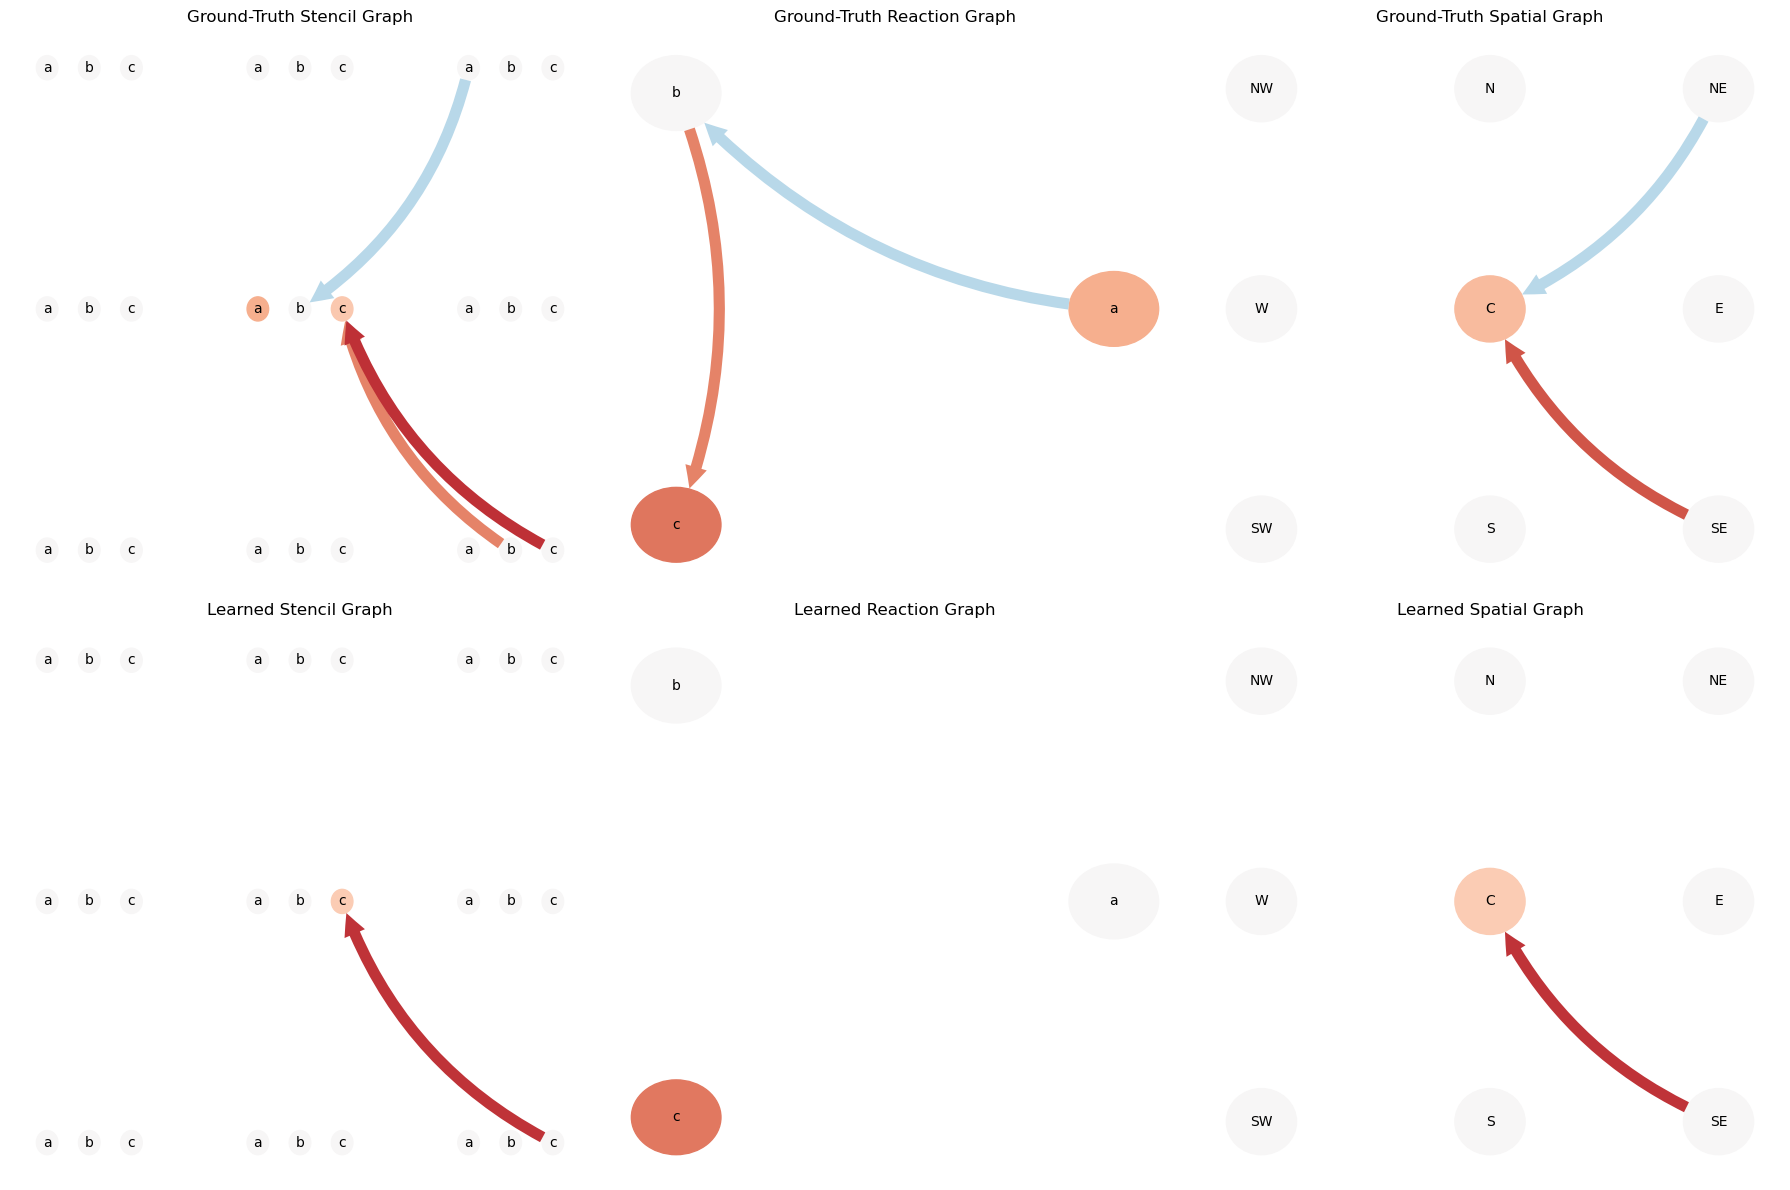

In [25]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 3, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
mcastle.plot_stencil_graph(stencil_graph=stencil_graph, stencil_val_matrix=stencil_val_matrix, ax=ax0, fig=fig)
ax0.set_title("Ground-Truth Stencil Graph")

ax1 = fig.add_subplot(gs[0, 1])
mcastle.plot_reaction_graph(reaction_graph=true_reaction_graph, reaction_val_matrix=true_reaction_vals, ax=ax1, fig=fig)
ax1.set_title("Ground-Truth Reaction Graph")

ax2 = fig.add_subplot(gs[0, 2])
mcastle.plot_stencil_graph(stencil_graph=true_spatial_graph, stencil_val_matrix=true_spatial_val_matrix, directional_var_names=True, ax=ax2, fig=fig)
ax2.set_title("Ground-Truth Spatial Graph")

ax3 = fig.add_subplot(gs[1, 0])
mcastle.plot_stencil_graph(stencil_graph=learned_stencil_graph, stencil_val_matrix=learned_stencil_vals, ax=ax3, fig=fig)
ax3.set_title("Learned Stencil Graph")

ax4 = fig.add_subplot(gs[1, 1])
mcastle.plot_reaction_graph(reaction_graph=learned_reaction_graph, reaction_val_matrix=learned_reaction_vals, ax=ax4, fig=fig)
ax4.set_title("Learned Reaction Graph")

ax5 = fig.add_subplot(gs[1, 2])
mcastle.plot_stencil_graph(stencil_graph=learned_spatial_graph, stencil_val_matrix=learned_spatial_val_matrix, directional_var_names=True, ax=ax5, fig=fig)
ax5.set_title("Learned Spatial Graph")

plt.tight_layout()
plt.show()